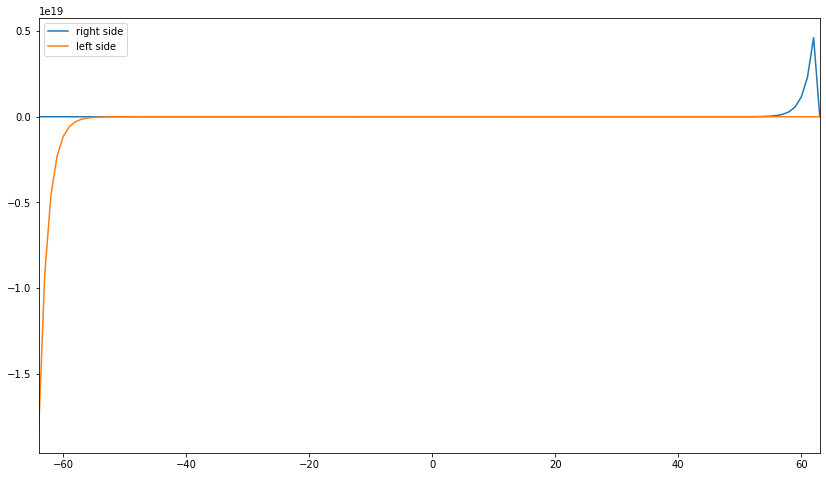

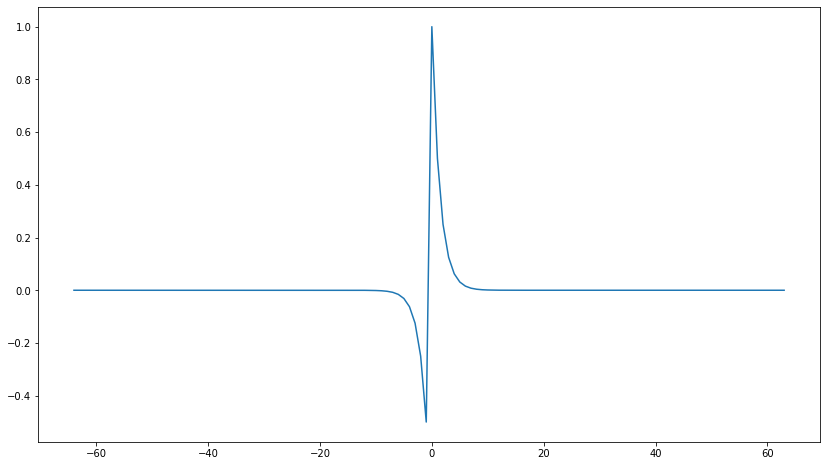

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve
from tqdm import tqdm
from DistantSpeech.beamformer.utils import pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms

a1 = 0.5
a2 = 2
h1 = np.array([2,-(a1+a2)])
h2 = np.array([1,-(a1+a2),a1*a2])

iir_length = 64
rtf1 = np.zeros(iir_length*2)
rtf2 = np.zeros(iir_length*2)
rtf3 = np.zeros(iir_length*2)

def stepfun(t, t0=0):
    return 1 if t >= t0 else 0

for n in np.arange(-iir_length, iir_length-1, 1, dtype=float):
    rtf1[int(n)+iir_length] = ((a1)**n)*stepfun(n)+(a2)**n*stepfun(n) # |z| >2
    rtf2[int(n)+iir_length]=(a1)**n*stepfun(n)-(a2)**n*stepfun(-n-1) # 0.5<|Z| <2
    rtf3[int(n)+iir_length]=-(a1)**n*stepfun(-n-1)-(a2)**n*stepfun(-n-1) #  |Z| <0.5

plt.figure(figsize=(14,8))
x_axis = np.linspace(-iir_length, iir_length-1, iir_length*2)

plt.plot(x_axis, rtf1)
plt.plot(x_axis,rtf3)
plt.xlim([-iir_length, iir_length-1])
plt.legend(['right side','left side'])
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_axis,rtf2)
plt.show()

64


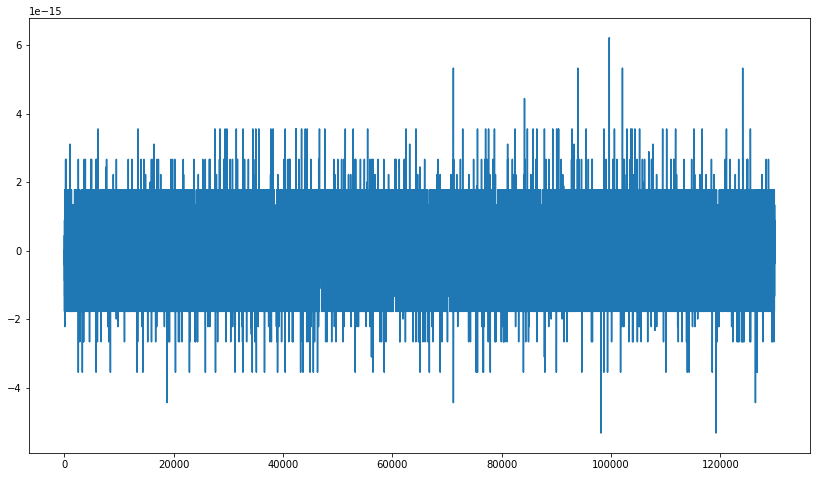

In [2]:
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
noise = np.random.randn(len(noise))
y1 = convolve(noise, h1)


y2 = convolve(noise, h2)
y2 = y2[:len(y1)]
# y2 = y2[32:]
# audiowrite('y1.wav', y1)
# audiowrite('y2.wav', y2)

# non-causal filtering
y1_est = convolve(y2, rtf2)

diff = np.zeros(iir_length*2)
# shift = iir_length
for shift in np.arange(0, iir_length*2, 1):
    y=y1_est[shift:]
    min_len = np.min((len(y), len(y1)))
    diff[shift] = np.sum((y1[:min_len]-y[:min_len])**2)
    # print(diff)

shift = np.argmin(diff)
y1_est = y1_est[shift:]
print(shift)

min_len = np.min((len(y1_est), len(y1)))

pt(y1[:min_len-iir_length]-y1_est[:min_len-iir_length])


100%|██████████| 129873/129873 [00:00<00:00, 249513.93it/s]


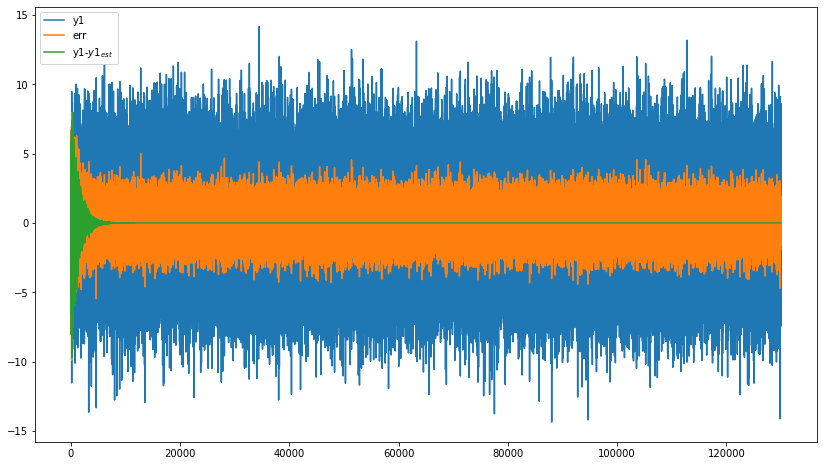

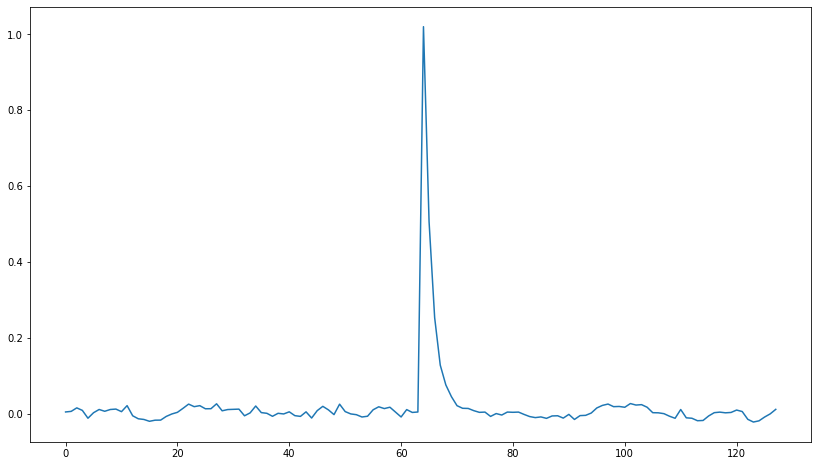

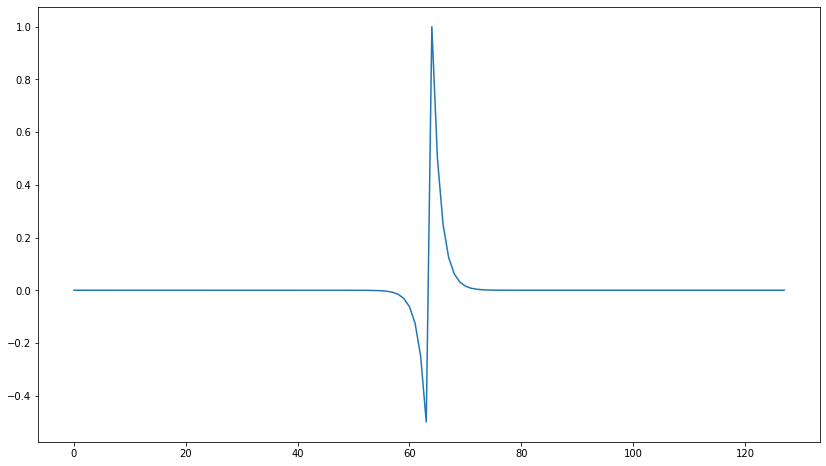

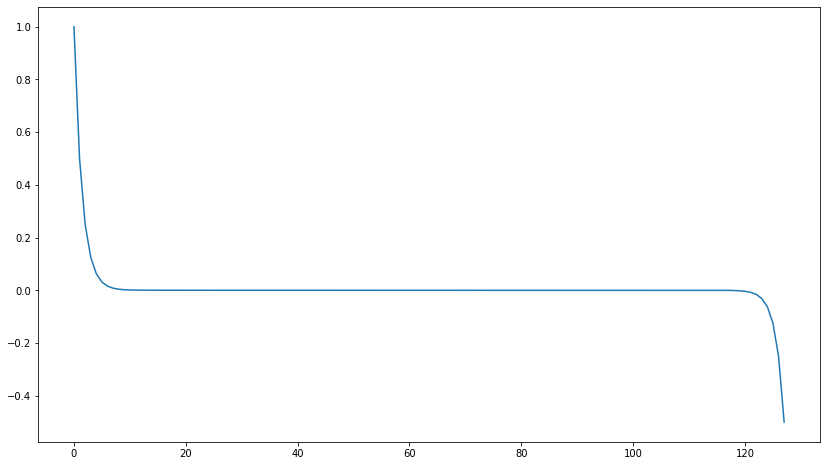

In [3]:
filter_len = iir_length*2
flms = FastFreqLms(filter_len=filter_len, mu=0.1, alpha=0.1)
flms_fir = FastFreqLms(filter_len=filter_len, mu=0.1, alpha=0.1, non_causal=True)

# y2 = y2[filter_len*4:]
# y1 = y1[:len(y1)]

y = y[iir_length:]

valid_len = len(y2)-flms.filter_len  # discard last frame

est_err_lms = np.zeros(valid_len)
est_err_nlms = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)
output = np.zeros(y1.shape)
output_fir = np.zeros(y1.shape)

for n in tqdm(range(len(y2) - filter_len)):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = y2[n: n +  flms.filter_len]
        d_vector = y1[n : n + flms.filter_len]
        
        err, w_flms = flms.update(input_vector, d_vector)
        output[n : n + flms.filter_len] = err[:, 0]

        err, w_flms_fir = flms_fir.update(input_vector, d_vector)
        output_fir[n : n + flms.filter_len] = err[:, 0]

plt.figure(figsize=(14,8))
plt.plot(y1)
plt.plot(output)
plt.plot(output_fir)
plt.legend(['y1','err','y1-$y1_{est}$'])
plt.show()
pt(np.fft.fftshift(w_flms))
pt((w_flms_fir))
pt(np.fft.fftshift(w_flms_fir))

y2 = y2[:len(y1)]

w_flms_shift = w_flms[:, 0] #np.fft.fftshift(w_flms[:, 0])
w_flms_fir_shift = np.fft.fftshift(w_flms_fir[:, 0])
# w_flms_shift[15] = -0.43
# w_flms_shift[14] = -0.2
# w_flms_shift[13] = -0.1
# w_flms_shift[12] = -0.01
# w_flms_shift[11] = 0.01
y = convolve(y2, w_flms_shift)
y = convolve(y2, rtf2)

# print(w_flms.shape)
# plt.figure(figsize=(14,8))
# plt.plot(rtf2)
# plt.plot(w_flms_shift)
# plt.plot(w_flms_fir_shift)
# plt.legend(['rtf2','w_flms_shift', 'w_flms_fir_shift'])
# plt.show()
# pt(rtf2,w_flms_shift)


# shift = 0
# diff = y1[:-shift]-y[shift:len(y1)+shift][:-shift]
# pt(diff)
# print(diff)

shift = iir_length
# for shift in range(filter_len):
#     diff = y1[:-shift]-y[shift:len(y1)+shift][:-shift]
#     print(np.sum(np.abs(diff)))
# pt(y1[:-shift], y1[:-shift]-y[shift:len(y1)+shift][:-shift])